# Building our own Quantizer: Custom Build an 8-Bit Quantizer

- Will quantize any model in `8-bit precision`.

- This quantizer is modality agnostic, meaning we can apply it on any model.
  - vision, audio, text, even multi model.

- Will use per channel Linear Quantization.

- Will create a `W8A16LinearLayer` class to store 8-bit weights and scales.

- Will replace all `torch.nn.Linear` layers with `W8A16LinearLayer`

- Then will build a quantizer and quantize a model end to end.

- Last but not the least will test the naive absmax quantization on many scenario and study its impact.




## Step 1: class `W8A16LinearLayer`
- Build the target class, `W8A16LinearLayer()`, that will be responsible for quantizing our model.

### 1.1 - `w8_a16_forward` Function
```Python
W8A16LinearLayer
                    # 8-bit  # 16-bit         # optional
* w8_a16_forward -> weights, input,   scales, bias=None
                    
```
- W8A16LinearLayer will first cast the 8-bit `weights` to the same data type as the `input`,
- For example, in the case the input is in float16 or bfloat16 -> "cast the weights" into that precision while keeping the weights into the same range as before.
- keeping the "casted weights" in the same range as before, [-128, 127]
- will just cast the data type of those weights in, half precision so that it will match the data type od the input.

- then will performe the linear operation "matrix multiplication btw the `input` and the `casted weights` with the scales of the model and optinally add the bais.


- Formula: $$(({inputs} \cdot \text{``casted weights''}) * {scale}) + {bias}$$

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

When we perform the matrix multiplication btw the `weight matrix` (int8) and the input `hidden states` (bfloat16), will have a vector of batch size output dim(1,32).
- So its important that the `scales` have the same shape as the output shape of weight matrix i.e (1,32)
- same goes with `bais` (1,32)

In [4]:
# some random inputs
# random int8 matrix
random_int8 = torch.randint(-128, 127, (32, 16)).to(torch.int8)
# random hidden state
random_hs = torch.randn((1, 16), dtype=torch.bfloat16)
# random scales
scales = torch.randn((1, 32), dtype=torch.bfloat16)
# random bias
bias = torch.randn((1, 32), dtype=torch.bfloat16)

In [5]:
# will frist cast the weights into the same data types as the hidden states.
# then on top of that will perform matrix multiplication ny calling F.linear() from pytorch
F.linear(random_hs, random_int8.to(random_hs.dtype))

tensor([[ 616.0000,  350.0000,   84.0000, -322.0000, -760.0000, -298.0000,
          -86.0000, -127.0000, -500.0000,   44.7500, -169.0000,  492.0000,
          250.0000,  356.0000,  139.0000, -169.0000,   68.5000,  -31.6250,
          191.0000, -352.0000,  580.0000,  -94.0000,  466.0000,   -2.4531,
          330.0000,  -27.7500, -366.0000,  -78.0000,  374.0000, -119.5000,
          170.0000,  296.0000]], dtype=torch.bfloat16)

In [6]:
# now will multiple hs * scales
F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales

tensor([[ 1.4600e+02,  8.6000e+01,  5.1250e+01,  6.9600e+02, -2.0320e+03,
          3.1400e+02,  3.1750e+01,  1.2300e+02,  6.0400e+02,  4.4500e+01,
          2.6375e+01,  5.6000e+02,  4.9400e+02,  6.5500e+01,  4.6500e+01,
          1.4700e+02, -1.7700e+02, -8.9375e+00, -6.7000e+01,  4.4800e+02,
         -4.5250e+01,  2.5300e+02, -2.5600e+02,  1.8750e+00, -2.5800e+02,
         -1.7875e+01,  4.0600e+02, -9.6500e+01, -3.3400e+02,  1.4750e+01,
         -7.6500e+01,  5.1200e+02]], dtype=torch.bfloat16)

In [7]:
# now added bias
(F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales) + bias

tensor([[ 1.4600e+02,  8.8500e+01,  5.2000e+01,  6.9600e+02, -2.0320e+03,
          3.1400e+02,  3.0375e+01,  1.2250e+02,  6.0400e+02,  4.4000e+01,
          2.6250e+01,  5.6000e+02,  4.9400e+02,  6.6000e+01,  4.4250e+01,
          1.4800e+02, -1.7700e+02, -9.0000e+00, -6.6500e+01,  4.4800e+02,
         -4.6250e+01,  2.5300e+02, -2.5800e+02,  1.9141e+00, -2.5800e+02,
         -1.7250e+01,  4.0800e+02, -9.9000e+01, -3.3400e+02,  1.3938e+01,
         -7.7500e+01,  5.1200e+02]], dtype=torch.bfloat16)

- Implement all this as a function, `w8_a16_forward`

In [8]:
# Defining the same into a method
def w8_a16_forward(weight, input, scales, bias=None):

    casted_weights = weight.to(input.dtype)
    output = F.linear(input, casted_weights) * scales

    if bias is not None:
        output = output + bias

    return output

In [9]:
# lets try out with and without bias
print("With bias:\n\n",
      w8_a16_forward(random_int8, random_hs, scales, bias))

print("\nWithout bias:\n\n",
      w8_a16_forward(random_int8, random_hs, scales))


With bias:

 tensor([[ 1.4600e+02,  8.8500e+01,  5.2000e+01,  6.9600e+02, -2.0320e+03,
          3.1400e+02,  3.0375e+01,  1.2250e+02,  6.0400e+02,  4.4000e+01,
          2.6250e+01,  5.6000e+02,  4.9400e+02,  6.6000e+01,  4.4250e+01,
          1.4800e+02, -1.7700e+02, -9.0000e+00, -6.6500e+01,  4.4800e+02,
         -4.6250e+01,  2.5300e+02, -2.5800e+02,  1.9141e+00, -2.5800e+02,
         -1.7250e+01,  4.0800e+02, -9.9000e+01, -3.3400e+02,  1.3938e+01,
         -7.7500e+01,  5.1200e+02]], dtype=torch.bfloat16)

Without bias:

 tensor([[ 1.4600e+02,  8.6000e+01,  5.1250e+01,  6.9600e+02, -2.0320e+03,
          3.1400e+02,  3.1750e+01,  1.2300e+02,  6.0400e+02,  4.4500e+01,
          2.6375e+01,  5.6000e+02,  4.9400e+02,  6.5500e+01,  4.6500e+01,
          1.4700e+02, -1.7700e+02, -8.9375e+00, -6.7000e+01,  4.4800e+02,
         -4.5250e+01,  2.5300e+02, -2.5600e+02,  1.8750e+00, -2.5800e+02,
         -1.7875e+01,  4.0600e+02, -9.6500e+01, -3.3400e+02,  1.4750e+01,
         -7.6500e+01,  

### 1.2 - `init` Function of class `W8A16LinearLayer`

_ Will start implementing the `__init__` method of that class.

- So for this linear layer we need to store the 8bit weights, the scales and the bais.
- This is how the `init` is of [PyTorch Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear):

```Python
def __init__(self, in_features, out_features, bias=True,
             device=None, dtype=None)
```
- It show be similar the the init method of torch linear layers, containing `input_feature`, `output_feature` in order the correctly initialize the input matrix (weights matrix bias).

- `bias=True` whether the linear layer has a bias term or not.
- `dtype` similar to the data type of the bias.
- Because our weigth matrix will have a torch that int8 as data type.

In [10]:
### running this will result in an error
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features,
                 bias=True, dtype=torch.float32):
      # here, will define int8 weights,together with the scales
        # that are going to be stored in the linear layer.
        super().__init__()
        #to create int8 weights, assigning the new attributes int8 weights,being a parm
        self.int8_weights = nn.Parameter(torch.Tensor([0, 1]
                                     ).to(dtype=torch.int8))
        #This approach is that when we create an nn. para
        # PyTorch expects that param where its able to compute gradients on it.
        # The issue is that with PyTorch we cant explicity compute gradients on int8 tensors

try:

    W8A16LinearLayer(1, 1)

except Exception as error:
    print("\033[91m", type(error).__name__, ": ", error, "\033[0m")

 RuntimeError :  Only Tensors of floating point and complex dtype can require gradients 


In [11]:
# the right approach to store int8 weights is instead of saving attributes as being
# an endless param, is to call this method called register buffer.
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features,
                 bias=True, dtype=torch.float32):
        super().__init__()

        # SIMPLE INFERENCE not TRAINNING (so only BUFFER)

        # so will use buffer, this way instead of storing a param, we just store a buffer.
        # meaning we dont need to compute gradint on the tensor
        self.register_buffer(
            "int8_weights",
            torch.randint( # and can be init. with any dtype here, torch.int8
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )
        # same for scales, init. with correct shapes
        self.register_buffer("scales",
                             torch.randn((out_features), dtype=dtype))
        # bias
        if bias:
            self.register_buffer("bias",
                                 torch.randn((1, out_features),
                                             dtype=dtype))

        else:
            self.bias = None

In [12]:
#Test your implementation.
dummy_instance = W8A16LinearLayer(16, 32)

In [13]:
# lets check
print(dummy_instance.int8_weights.shape)
print(dummy_instance.scales.shape)

torch.Size([32, 16])
torch.Size([32])


Great all the ecpected attributes have the expected shape.

- next will build forward pass

### 1.3 - `forward` Function of class `W8A16LinearLayer`

- Use the `w8_a16_forward` defined earlier (Step 1.1) to define the `forward` function.

In [14]:
# Call the method that already defined
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features,
                 bias=True, dtype=torch.float32):
        super().__init__()


        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )

        self.register_buffer("scales",
                             torch.randn((out_features), dtype=dtype))

        if bias:
            self.register_buffer("bias",
                                 torch.randn((1, out_features),
                                             dtype=dtype))

        else:
            self.bias = None

    # simply going to call it on self.int8_wights,scales,bias
    # this method will do everything under the hood for us, will take care of
    # casting weights into correct dtype and multiplying everything with the scale and adding bias
    def forward(self, input):
        return w8_a16_forward(self.int8_weights,
                              input, self.scales, self.bias)

In [15]:
# will create a new module
module= W8A16LinearLayer(16, 32) #input and output shape
dummy_hidden_state = torch.randn(1,6, 16)  # with the shape batch size 1
 #(seq length 6, hidden shape which should match the input hs)

In [16]:
module(dummy_hidden_state).shape

torch.Size([1, 6, 32])

We still have batch size, seq length, output shape

In [17]:
module(dummy_hidden_state).dtype

torch.float32

now we have a forward pass that is working and a linear layer class that has all the needed attributes.
- we need to build, quantize method in order to perform quantization algo.

- Once we have defined quantize method, the workflow will be:
  - will have a base model (lets say in half precision) either Fp16 or Vf16
  - will loop over all the linear layer classes, replace them with our new linear class, and then call quantize by passing the old weights in order to quantize the old weights into int8.

### 1.4 - `quantize` Function of class `W8A16LinearLayer`

- `quantize` function will dynamically quantize half-precision weights into `torch.int8`

In [38]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features,
                 bias=True, dtype=torch.float32):
        super().__init__()


        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )

        self.register_buffer("scales",
                             torch.randn((out_features), dtype=dtype))

        if bias:
            self.register_buffer("bias",
                                 torch.randn((1, out_features),
                                             dtype=dtype))

        else:
            self.bias = None

    #will define quantize
    # it will take the original weights as input
    # it will quantize the weights in int8 precision
        # get the scales of the quantization
        # and manually assign int8 weights and scales to the
        # computed quantized weights and scales.

    def quantize(self, weights):
      # first will upcast the weights in FP32 for stability
        w_fp32 = weights.clone().to(torch.float32)

        # scale formula: will get the abs values of the weights
        # get the max on the last dim and divide it by 127 to get the scale
        scales = w_fp32.abs().max(dim=-1).values / 127
        # making sure the same dtype as the input weights
        scales = scales.to(weights.dtype)

        # applying linear quantization formula (here, per-channel LQ)
        # as we getting the max on each ele of the last dim.
        int8_weights = torch.round(weights
                        /scales.unsqueeze(1)).to(torch.int8)
        # assigning int8_weights and scales
        self.int8_weights = int8_weights
        self.scales = scales
    # forward passs stays the same
    def forward(self, input):
        return w8_a16_forward(self.int8_weights,
                              input, self.scales, self.bias)

In [19]:
module = W8A16LinearLayer(4, 8)

In [20]:
print("Weights before:\n" , module.int8_weights)

Weights before:
 tensor([[ -20,  107,   97, -119],
        [  93,  110,   79, -100],
        [ -72,  -58,  -24,  -93],
        [ -81, -123,   71, -106],
        [-127,   43,  -41,   53],
        [  92, -120,   94,  -86],
        [-123,  -49,   98,    9],
        [  59,  -72,  -13,   -2]], dtype=torch.int8)


In [21]:
# passing dummy random orginal weights here,
random_matrix = torch.randn((4, 8), dtype=torch.bfloat16)

In [22]:
module.quantize(random_matrix)

In [23]:
print("Weights After:\n" , module.int8_weights)

Weights After:
 tensor([[  82,  -92,   74, -127,   12,  103,   62,    4],
        [  45,   13,   53,   40,  -72,  127,   38,   78],
        [ 110, -127,  -23,   84,   86,   42,   12, -105],
        [  27,   50,  -71,  -26,  -94,   40,  127,    9]], dtype=torch.int8)


we see the weigths tensor are completely different because we quantized the module with the correct weights.

- also int8 weights are in btw -128 to 127

In [24]:
# inspect scapes of our quantize module
module.scales

tensor([0.0149, 0.0146, 0.0101, 0.0093], dtype=torch.bfloat16)

In [25]:
# shape
module.scales.shape



torch.Size([4])

So we have a tensor of size 4 which is the expected output shape

In [26]:
# same as input
module.int8_weights.shape

torch.Size([4, 8])

In [27]:
# lest compare
module.int8_weights*module.scales.unsqueeze(1)

tensor([[ 1.2188, -1.3672,  1.1016, -1.8906,  0.1787,  1.5312,  0.9219,  0.0596],
        [ 0.6602,  0.1904,  0.7773,  0.5859, -1.0547,  1.8594,  0.5547,  1.1406],
        [ 1.1172, -1.2891, -0.2334,  0.8516,  0.8711,  0.4258,  0.1216, -1.0625],
        [ 0.2520,  0.4668, -0.6641, -0.2432, -0.8789,  0.3730,  1.1875,  0.0840]],
       dtype=torch.bfloat16)

In [28]:
random_matrix

tensor([[ 1.2266, -1.3672,  1.1016, -1.8906,  0.1748,  1.5312,  0.9258,  0.0540],
        [ 0.6562,  0.1963,  0.7773,  0.5781, -1.0625,  1.8594,  0.5508,  1.1406],
        [ 1.1172, -1.2891, -0.2324,  0.8438,  0.8711,  0.4297,  0.1221, -1.0625],
        [ 0.2500,  0.4629, -0.6641, -0.2451, -0.8711,  0.3691,  1.1875,  0.0845]],
       dtype=torch.bfloat16)

In [29]:
# lets sub and see the change (error or loss)
(random_matrix-module.int8_weights*module.scales.unsqueeze(1)).abs().mean()

tensor(0.0026, dtype=torch.bfloat16)

perfect

# Replace PyTorch Layers with Quantized Layers

## Step 2: Quantization Pipeline
- Replace all of the `torch.nn.Linear` layers with the `W8A16LinearLayer` layer.
- Call `quantize` on the linear layers using the original weights.

We have now all our building blocks to bulid our quantizer.
- So the quantizer is going to be a quantization pipeline that will, iterate over all linear modules of your original model.
- And replace them with our new `W8A16`, Linear layer module and call quantize on using the orignial weights.

### 2.1 - Model In-place Linear Layer Replacement
- Implement `replace_linear_with_target`

In [39]:
# So lets first build, a method called replace linear with target
# That is going to loop over the model, identify the modules that are instance of torch that
# is not linear and replace it with the new module.

# takes module (model) and it follows a recursive method
# takes a target_class, the new class that we gonna set in replacement to the linear layer
# and module_name_to_exclude is the name of the module that we'er going to exclude in this replacement logic

# later will see of LLM that usually its better to keep the last module unquantized for better results.
# so module_name_to_exclude will be useful in that specific case.
def replace_linear_with_target(module,
                               target_class, module_name_to_exclude):
  # we are going to simply loop over the modules named children.
    for name, child in module.named_children():
      # and if the sub module is an instance of an nn.linear and we dont have any
      #name that matches the names that are inside the module name to exclude,
      # then we're going to move forward with the module replacement.
        if isinstance(child, nn.Linear) and not \
          any([x == name for x in module_name_to_exclude]):
          # So we are goin to get the bias of the sub module here,
          # as we are goin to use it to create our new target class.
            old_bias = child.bias
            # then we create our new module,
            #which is goin to the target class of child
            # so in features out features shloud be the same as the linear layers.
            new_module = target_class(child.in_features,
                                      child.out_features,#the orignial layers one bias
                                      old_bias is not None, # we are just simply going to check  if old bias is not "none"
                                      child.weight.dtype) # same datatype as the submodules weights
            setattr(module, name, new_module) # will call set attributes to the parent module
            # will replace the curr attribute of the module by calling setattr module, name
            # becasue name gives you the name of the current attr we r going to mod. and the new_module. {name}-> new_module

            # if the old module has a bias
            if old_bias is not None:
              # we r goin to explicitly set the bias of the new module to old bias.
              getattr(module, name).bias = old_bias
        else:
            # Recursively call the function for nested modules

            # so if not this {if isinstance(child, nn.Linear) and not} case, will call
            # the method again on the child module
            replace_linear_with_target(
                child, #child module
                target_class, module_name_to_exclude) # usig same arg

In [48]:
# create a dummy module for testing purpose.
# with two linear layers
# one lm head : which is usualy the last module in a transformer model.


class DummyModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.emb = torch.nn.Embedding(1, 1)
    # Try with bias
    self.linear_1 = nn.Linear(1, 1)
    # Try without bias
    self.linear_2 = nn.Linear(1, 1, bias=False)
    # Lm prediction head
    self.lm_head = nn.Linear(1, 1, bias=False)

In [49]:
# will create two more models as the model modifies inplace.
# model 1 where we goin to test out the module name to exclude feature
model_1 = DummyModel()
#model 2 which is just going to replace all linear layers instances with the new ones
model_2 = DummyModel()

In [50]:
# trying first case
replace_linear_with_target(model_1, W8A16LinearLayer, ["lm_head"])
print(model_1)

DummyModel(
  (emb): Embedding(1, 1)
  (linear_1): W8A16LinearLayer()
  (linear_2): W8A16LinearLayer()
  (lm_head): Linear(in_features=1, out_features=1, bias=False)
)


- perfect we were able to replace all linear layers with W8A16LinearLayer()
- where lm_head remained

In [51]:
replace_linear_with_target(model_2, W8A16LinearLayer, [])
print(model_2)

DummyModel(
  (emb): Embedding(1, 1)
  (linear_1): W8A16LinearLayer()
  (linear_2): W8A16LinearLayer()
  (lm_head): W8A16LinearLayer()
)


- as we passed empty list, lm_head was also replaced.

### 2.2 - Linear Layer Replacement + Quantization
- Modify the `replace_linear_with_target` function to also perform quantization.
- Implement `replace_linear_with_target_and_quantize`.

In [45]:
def replace_linear_with_target_and_quantize(module,
                               target_class, module_name_to_exclude):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and not \
        any([x == name for x in module_name_to_exclude]):
            old_bias = child.bias
            # will retrive the old weights
            old_weight = child.weight

            new_module = target_class(child.in_features,
                                      child.out_features,
                                      old_bias is not None,
                                      child.weight.dtype)
            setattr(module, name, new_module)

            #quantization should happemd here
            #once we have replaced the module with the new module
            # we can get that module again with get attribute (module name)

            getattr(module, name).quantize(old_weight) #at this point, `setattr(module, name, new_module)` should return the new module
            # and call quantize and pass the old weight
            if old_bias is not None:
              getattr(module, name).bias = old_bias
        else:
          # updates
            # Recursively call the function for nested modules
            replace_linear_with_target_and_quantize(child, S
                     target_class, module_name_to_exclude)

In [53]:
#with new dummy model, will try
model_3 = DummyModel()

In [47]:
replace_linear_with_target_and_quantize(model_3, W8A16LinearLayer, ["lm_head"])
print(model_3)

DummyModel(
  (emb): Embedding(1, 1)
  (linear_1): W8A16LinearLayer()
  (linear_2): W8A16LinearLayer()
  (lm_head): Linear(in_features=1, out_features=1, bias=False)
)


- great it worked keeping the lm_head

Here, we have tried on the dummies, now time for real use cases!!!

# Quantize any Open Source PyTorch Model

## Step 3: Test the Implementation on Various LLMs

### 3.1 Will use [Salesforce/codegen-350M-mono](https://huggingface.co/Salesforce/codegen-350M-mono) model from hugging face.

- So this is a LM that has been fine-tuned in code.
- And it has only 350million parameters.
- Lets use transformers to load the model with tokenizer nd get some generation.

In [56]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_id = "Salesforce/codegen-350M-mono"

model = AutoModelForCausalLM.from_pretrained(model_id,
                                    torch_dtype=torch.bfloat16,
                                             low_cpu_mem_usage=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/797M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [65]:
# the text generation piple to generate text
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

In [66]:
# lets seee, as it is a model trainned and fine tuend on code, lets ask the model to complete code.
print(pipe("def hello_world():", max_new_tokens=20, do_sample=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'def hello_world():\n    print("Hello World")\n\n# hello_world()\n\n# def hello_'}]


- so yeah the model completed the code, defined a function to print "Hello world"

In [67]:
#before quantization
print("Model before:\n\n", model)

Model before:

 CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): W8A16LinearLayer()
          (out_proj): W8A16LinearLayer()
        )
        (mlp): CodeGenMLP(
          (fc_in): W8A16LinearLayer()
          (fc_out): W8A16LinearLayer()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias=True)
)


This is how to model looks like!
- lot of linear layers because it a transformer based architecture.
- so most of the weights comes from , some linear layers on the model.


In [68]:
#lets call our quantization function
# replace linear with target and quantize model, TargetClass -> W8A16LinearLayer
# we r not quant {lm_head} because the model is an autoregressive model.
# it usses the output from the prev. iteration to get the output of the next iteration.
replace_linear_with_target_and_quantize(model, # inplace model modification
                                        W8A16LinearLayer, ["lm_head"])

# if we quantize lm_head we might get errors.

In [70]:
# inspect
pipe.model

CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): W8A16LinearLayer()
          (out_proj): W8A16LinearLayer()
        )
        (mlp): CodeGenMLP(
          (fc_in): W8A16LinearLayer()
          (fc_out): W8A16LinearLayer()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias=True)
)

- it confirms the model has been quantized, we see "W8A16LinearLayer()"

In [71]:
# lets try again
print(pipe("def hello_world():", max_new_tokens=20,
           do_sample=False)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def hello_world():
    print("Hello World")

# hello_world()

# def hello_


In [74]:
# lets try sun of 5 natural numbers
print(pipe("def sum_of_natural_numbers(5):", max_new_tokens=60,
           do_sample=False)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def sum_of_natural_numbers(5):
    """Return sum of all numbers from 1 to 5."""
    sum = 0
    for i in range(1, 6):
        sum += i
    return sum

# print(sum_of_natural_numbers(5))

# def fact


- so yeah model has successfully generated code for sum of n=5 natural numbers. After being quantized.

## Lets try out to quantize an object detection model

### 3.2 So now lets use, [facebook/detr-resnet-50](https://huggingface.co/facebook/detr-resnet-50) an object detection model.
- Its an architecture that has been designed by Facebook AI

In [76]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests

url="http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")

In [77]:
previous_memory_footprint = model.get_memory_footprint()

In [78]:
print("Footprint of the model in MBs: ",
      previous_memory_footprint/1e+6)

Footprint of the model in MBs:  166.524032


In [82]:
#connecting to google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


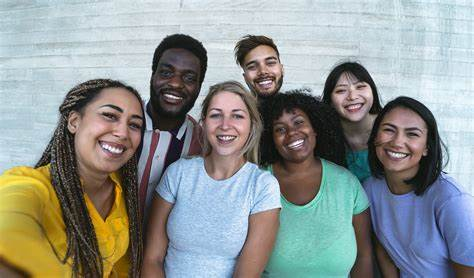

In [85]:
img_path = "/content/drive/MyDrive/Rakuten/img/OIP.jpg"
image = Image.open(img_path).convert("RGB")
image

In [86]:
#Visualization
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(model, pil_img, results):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    scores, labels, boxes = results["scores"], results["labels"], results["boxes"]
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


In [87]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

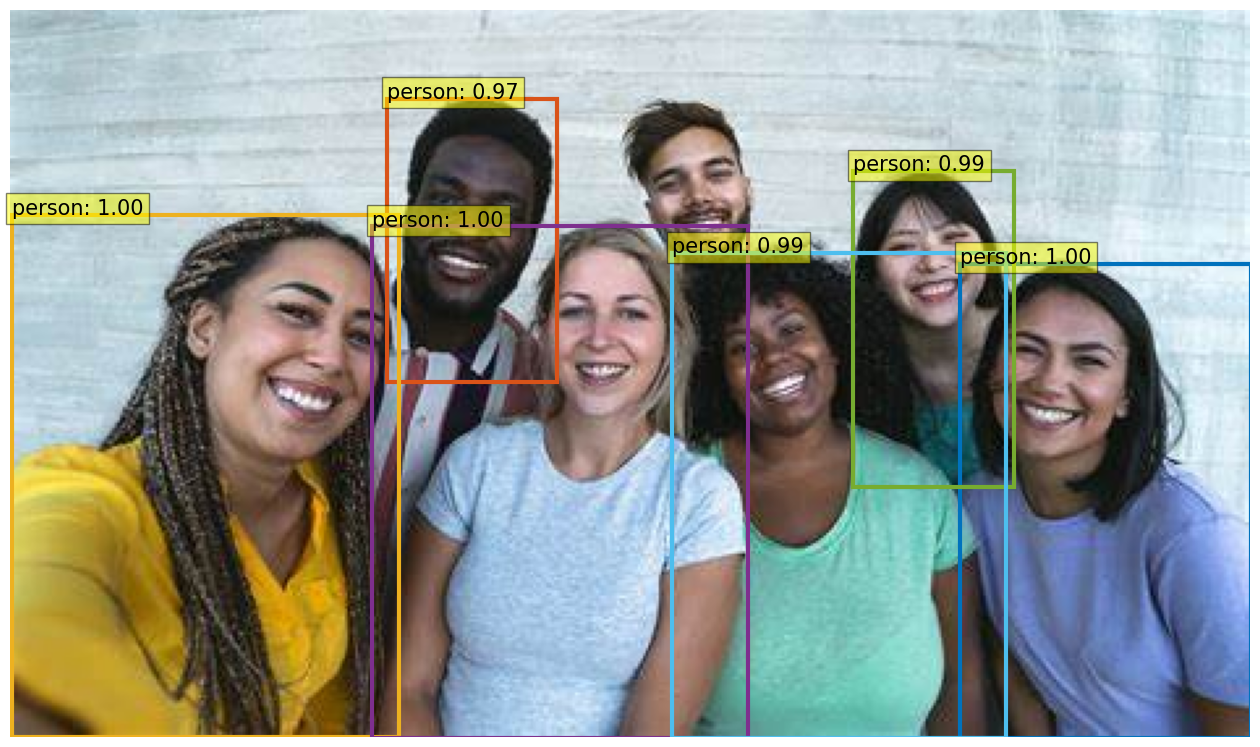

In [88]:
plot_results(model, image, results)

In [89]:
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [90]:
replace_linear_with_target_and_quantize(model,
                                        W8A16LinearLayer,
               ["0", "1", "2", "class_labels_classifier"])

In [91]:
### Model after quantization
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

- we have replaced the linear layers with `W8A16LinearLayer`

In [92]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

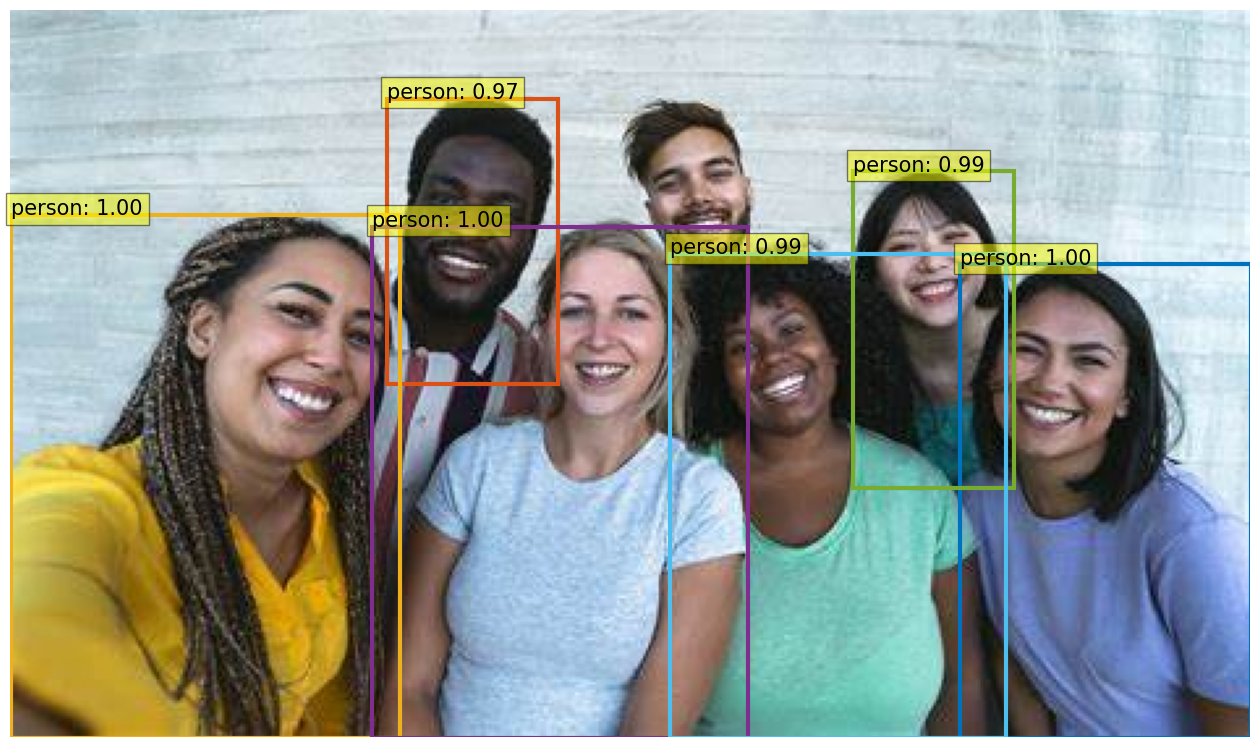

In [93]:
plot_results(model, image, results)

- Result is similar to the origianl model

In [94]:
#to see memory usage
new_footprint = model.get_memory_footprint()

In [95]:
print("Footprint of the model in MBs: ",
      new_footprint/1e+6)

Footprint of the model in MBs:  114.80384


- We saved around 50mb here!

In [96]:
### Memory saved
print("Memory saved in MBs: ",
      (previous_memory_footprint - new_footprint)/1e+6)

Memory saved in MBs:  51.720192
